# Demos: Lecture 16

In [1]:
import pennylane as qml
from pennylane import numpy as np
from itertools import chain

from lecture16_helpers import *

## Demo 1: QAOA from scratch

Our Hamiltonians:


\begin{equation*}
 \hat{H}_{c} =  \sum_{ij \in E} \left( Z_{i}  +  Z_{j} +
   Z_{i} Z_{j}\right) - 2 \sum_{i \in V}  Z_{i} 
\end{equation*}

\begin{equation*}
\hat{H}_{m} = \sum_{i} X_{i}
\end{equation*}

<img src="fig/qaoa.png">

In [2]:
edges = [(0, 1), (1, 2), (2, 3), (3, 4), (4, 0), (1, 4)]

edge_term_ops = [
    [qml.PauliZ(i), qml.PauliZ(j), qml.PauliZ(i) @ qml.PauliZ(j)] 
    for (i, j) in edges
]
edge_term_ops = list(chain(*edge_term_ops))

edge_term_coeffs = [1] * len(edge_term_ops)    

vertex_term_ops = [qml.PauliZ(i) for i in range(5)]
vertex_term_coeffs = [-2] * len(vertex_term_ops)

In [3]:
H_edge = qml.Hamiltonian(edge_term_coeffs, edge_term_ops)
H_vertex = qml.Hamiltonian(vertex_term_coeffs, vertex_term_ops)
H_cost = H_edge + H_vertex

In [4]:
print(H_cost)

  (1) [Z1]
+ (1) [Z4]
+ (1) [Z0 Z1]
+ (1) [Z1 Z2]
+ (1) [Z2 Z3]
+ (1) [Z3 Z4]
+ (1) [Z4 Z0]
+ (1) [Z1 Z4]


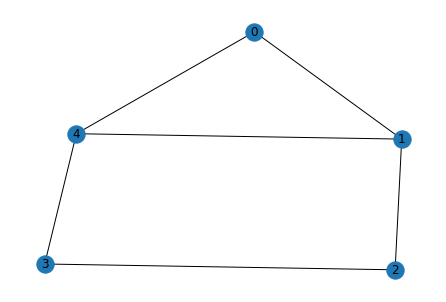

In [5]:
plot_graph(edges)

In [6]:
mixer_ops = [qml.PauliX(i) for i in range(5)]
mixer_coeffs = [1] * len(mixer_ops)

H_mixer = qml.Hamiltonian(mixer_coeffs, mixer_ops)

In [7]:
print(H_mixer)

  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]


In [8]:
dev = qml.device("default.qubit", wires=5)

n_layers = 5
alpha_m = np.random.normal(size=n_layers)
beta_c = np.random.normal(size=n_layers)

In [10]:
def qaoa_circuit(alpha_m, beta_c):
    for wire in range(5):
        qml.Hadamard(wires=wire)
        
    for layer_idx in range(n_layers):
        qml.ApproxTimeEvolution(H_cost, beta_c[layer_idx], 1)
        qml.ApproxTimeEvolution(H_mixer, alpha_m[layer_idx], 1)
        
@qml.qnode(dev)
def cost_function(alpha_m, beta_c):
    qaoa_circuit(alpha_m, beta_c)
    return qml.expval(H_cost)

@qml.qnode(dev)
def compute_probs(alpha_m, beta_c):
    qaoa_circuit(alpha_m, beta_c)
    return qml.probs(wires=range(5))

In [12]:
opt = qml.GradientDescentOptimizer(stepsize=0.01)

n_its = 100

for _ in range(n_its):
    alpha_m, beta_c = opt.step(cost_function, alpha_m, beta_c)

In [13]:
alpha_m

tensor([ 0.97715516, -0.64342276, -0.3845935 ,  0.26616884, -0.46609436], requires_grad=True)

In [14]:
compute_probs(alpha_m, beta_c)

tensor([6.25254991e-04, 1.12312651e-03, 8.18125452e-04, 6.23268305e-04,
        8.18125452e-04, 1.35714654e-01, 1.06679763e-03, 1.43306928e-04,
        1.12312651e-03, 1.55299948e-01, 1.35714654e-01, 1.44906440e-01,
        6.23268305e-04, 1.44906440e-01, 1.43306928e-04, 6.58800441e-04,
        8.88737508e-05, 6.76066456e-04, 2.28195933e-04, 1.36406640e-03,
        2.28195933e-04, 1.30716390e-01, 4.87990941e-03, 8.50915661e-04,
        6.76066456e-04, 1.46418527e-03, 1.30716390e-01, 7.58790914e-04,
        1.36406640e-03, 7.58790914e-04, 8.50915661e-04, 6.95380245e-05], requires_grad=True)

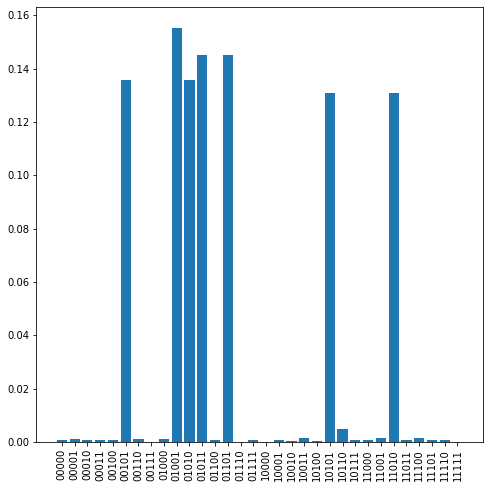

In [15]:
plot_probs(compute_probs(alpha_m, beta_c))

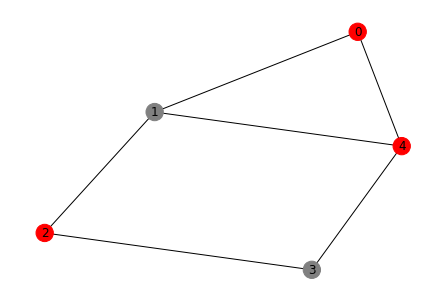

In [19]:
plot_graph(edges, solution_string="10101")